In [1]:
import numpy as np
import pdb
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


# <center> Math 579: Assignment 3 </center>

In this assignment we will be using the finite element method to obtain solutions to the Poisson equation with Dirichlet boundary conditions,

\begin{align} \tag{1}
-\Delta u &= f  &\text{    in    } \Omega 
\\
u &= g &\text{    on    } \partial\Omega
\end{align}


where $\Omega \subset \mathbb{R}^2$ bounded, $f \in L^2\left(\Omega\right)$ and $g \in L^2(\partial\Omega)$. We will first devise an implementation that is able to handle at least one convex domain (such as a square or a triangle), a domain with a reentrant corner (such as an L-shaped domain), inhomogeneous Dirichlet boundary conditions, and a refinement procedure. The implementation will then be tested against a series of numerical experiments to see if the numerical results agree with the theory.

### <center> Weak Formulation </center>
----
    
In order to account for the inhomogeneous boundary condition, we first let $w = u - g$ and consider the function space,

\begin{equation*}
H^1_{g} = \left\{ u \in H^1(\Omega) | \;\; u\rvert_{\partial \Omega} = g \right\}
\end{equation*}

Provided that g admits an extension, G, to the whole domain, this allows us to reformulate the weak problem as: find $w \in H^{1}_0 \left(\Omega\right)$ s.t.

\begin{equation*} \tag{2}
\int_{\Omega} \nabla w \cdot \nabla v = \int_{\Omega} f v   - \int_{\Omega} \nabla G \cdot \nabla v, \;\; \forall \,v \in H^1_0(\Omega)  
\end{equation*}


### <center> Galerkin Discretization </center>
----

We consider discrete formulation of the problem begins by  the finite dimensional subspaces $X_n \subset H^1(\Omega)$ and $X^0_n \subset X_n \cap H^1_0(\Omega)$. We partition the domain using a conforming triangulation $P$, containing $N$ vertices. As an interpolation basis for $X_n$, we take the nodal interpolants $\left\{\phi_i \right\}_{i}$ where $i = 1,2,..., N$. The basis elements are linear in every element $\tau \in P$ and satisfy:

\begin{equation*}
\phi_i(x_k) = \delta_{i,k}
\end{equation*}

where $x_k$ is the coordinate of the $k^{th}$ vertex. The subspace $X^0_n$ is spanned by $\left\{\phi_k \right\}_{k} \subset \left\{\phi_i \right\}_{i}$, for $k \in I$ where $I$ is an index set containing only labels for the interior nodes. The extension of the Dirichlet condition is then given by,

\begin{equation*}
G(x) = \sum_{k=1}^N g_k \phi_k(x)
\end{equation*}

and the numerical solution is given by

\begin{equation*}
U(x) = \sum_{i \in I} x_k\phi_k(x) + G(x)
\end{equation*}

where the $x_k$ come from the solution of the linear system

\begin{equation*}
Ax = b.
\end{equation*}

This linear system represents the discretization of the weak formulation given by (2). More explicitly, the entries of the stiffness matrix are given by,

\begin{equation*}
A_{ik} = \sum_{\tau \in P} \int_{\tau} \nabla\phi_i \cdot \nabla \phi_k
\end{equation*}

and the entries of the RHS are given by

\begin{equation*}
\sum_{\tau \in P} \int_{\tau} f\phi_i - \sum_{k = 1}^N G_k \sum_{\tau \in P} \int_{\tau} \nabla\phi_i \cdot \nabla \phi_k . 
\end{equation*}


The assembly of the stiffness matrix and RHS are done exactly as described in the reference (https://www.math.hu-berlin.de/~cc/cc_homepage/software/software.shtml). We now present code used to implement the numerical solution of (1), with sufficient commentary on the subtleties that arise.  


## <center> Data structures and routines </center>

We first consider triangulating a square domain in $\mathbb{R}^2$ with corners $(0,0), (0,1), (1,0), (1,1)$ and an equal number of nodes along each axis. 



In [2]:
# Triangulation Code
# In general I'm defining classes for the aspects that wish to be sufficiently general and functions for the
# aspects that are problem specific

def Square_Triangulate(N):

    x_coords = np.linspace(0, 1, N, endpoint = True)
    y_coords = np.linspace(0, 1, N, endpoint = True)

    # Put this into a meshgrid for easier access to coordinate values.

    [X,Y] = np.array(np.meshgrid(x_coords, y_coords))
    #Put this in a more convenient form:
    Nodes = np.zeros([N**2, 3])
    Nodes[:,0], Nodes[:,1], Nodes[:,2] = np.arange(0,int(N**2), dtype = int), X.reshape([N**2,]), Y.reshape([N**2,])

    # Labelling will be from left to right, from bottom to top.

    # Need a way of identifying elements in order to define stiffness matrices

    # Create element (M X 4) data structure:
    # M is the number of elements

    # E = [lower left node | next nearest node | next nearest node]
    M = 2*N*(N-1)
    E = np.zeros([M-2, 4], dtype = int)  # -2 to account for indexing from 0
    E[:,0] = np.arange(0, M-2, dtype = int) # "--------=----------"

    #triangulation
    for i in range(0, (N-1)*N -1):
        #triangle below
        E[2*i,1] = int(i)
        E[2*i,2] = int(i + 1)
        E[2*i,3] = int(i + N + 1)

        #triangle above
        E[2*i+1,1] = int(i)
        E[2*i+1,2] = int(i + N)
        E[2*i+1,3] = int(i+ N + 1)


    return E, Nodes, [X,Y]




In [3]:

# Code to assemble elemental stiffness matrices:
class Stiffness(object):

    def __init__(self, Elements, Nodes):
        self.E = Elements
        self.Nodes = Nodes
        return

    def loc(self, element = 0):
        # returns local stiffness matrix for a certain element
        N_s = self.E[element, :][1::]

        x_s = self.Nodes[N_s, 1]
        y_s = self.Nodes[N_s, 2]

        T = 0.5*abs(((x_s[1]- x_s[0])*(y_s[2]-y_s[0]) - \
                 (x_s[2]-x_s[0])*(y_s[1]-y_s[0])))

        Gg = np.linalg.inv(np.array([[1,1,1],x_s,y_s]))
        g = np.array([[0,0],[1,0],[0,1]])
        G = np.matmul(Gg, g)
        M = (T/2)*np.matmul(G, G.T)

        return M

#------------------------------------------------------------------------------

# RHS assembly

class RHS(object):
    """
    Class to store the RHS of our problem,
    input is the forcing function (RHS) of the problem

    input: F[X,Y]: Omega \to R^N,
    N is the number of nodes, X,Y \in R^{N^2}.
    """

    def __init__(self, f, g, elements, nodes):
        # make sure these are callable
        self.f = f
        self.g = g
        self.E = elements
        self.Nodes = nodes
        return

    def b(self, boundary):
       # Calculates volume force at every node
        F_vol = np.zeros([len(self.Nodes[:,0]),], dtype = "float")
        for e in range(len(self.E[:,0])):
            n_s = self.E[e, 1::]
            [X,Y] = [self.Nodes[n_s, 1], self.Nodes[n_s,2]]
            J = (X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0])
            # J = np.array([[1,1,1], X, Y])
            # J_det = np.linalg.det(J)
            # Calculate centre of mass
            x_s, y_s = np.sum(X)/3, np.sum(Y)/3

            f_vol = self.f(x_s,y_s)

            for n in n_s:
                F_vol[n] += (1/12)*abs(J)*f_vol

        return F_vol


def on_boundary(Nodes):

    bn = [] # Boundary nodes
    eps = 1e-8
    for i in range(len(Nodes[:,0])):
        n, x, y = Nodes[i,0], Nodes[i,1], Nodes[i,2]

        # This is just for the square

        if (x < eps) or x > (1 - eps) or y < eps or y > (1-eps):
            bn.append(int(n))

    return bn

def L_boundary(Nodes):
    bn = []
    eps = 1e-8
    for i in range(len(Nodes[:,0])):
        n, x, y = Nodes[i,0], Nodes[i,1], Nodes[i,2]
        if (y > (1-eps)) or (y < (-1 + eps)) or (x > (1-eps)) or (x < (-1 + eps)) \
        or (x > (0 - eps) and y < (0 + eps)):
            bn.append(int(n))

    return bn




In [4]:
#------------------ Algorithm implementation--------------------------------
def Solve(mesh_func, N, U_exact, F, boundary):


    # Set up computational domain
    E, Nodes, Mesh = mesh_func(N)

    # Identify boundary
    bn = boundary(Nodes)


    M = Stiffness(E, Nodes)
    rhs = RHS(f = F, g = U_exact, elements = E, nodes = Nodes)

    # Extension of initial condition is just U itself.

    #Assemble full Stiffness matrix and then delete boundary data:
    A = np.zeros([N**2,N**2], dtype = "float")
    for e in E[:,0]:
        N_s = E[e,1::]
        M_loc = M.loc(e)
        for i in range(3):
            for j in range(3):
                A[N_s[i], N_s[j]] += M_loc[i,j]

    B = rhs.b(boundary = bn)

    # remove nodes corresponding to boundary data:

    # for the array it's a bit trickier
    # first define a list without the elements in bn
    nns = np.arange(0, N**2)

    not_bn = np.array([x for x in nns if x not in bn])

    #delete these rows and columns
    A_in = A[not_bn,:][:,not_bn]

    # Apply M to G
    G_init = U_exact(Mesh[0], Mesh[1])
    u_D = G_init.reshape([N**2,]).copy()
    # Set G to zero except for the boundary.
    u_D[not_bn] = 0.

    AG = np.matmul(A[not_bn,:], u_D)

    B_in = B[not_bn] - AG


    # Finally invert
    U_in = np.matmul(np.linalg.inv(A_in), B_in)

    # Combine with boundary data:
    U  = np.zeros([N**2,], dtype = "float")
    U[not_bn] = U_in
    U += u_D

    U = U.reshape([N,N])

    return U, G_init


def H1_norm(E, Nodes, U, which = None):

    #Assemble full Stiffness matrix and then delete boundary data:
    N = len(Nodes[:,0])
    A = np.zeros([N,N], dtype = "float")
    M = Stiffness(E, Nodes)

    for e in E[:,0]:
        N_s = E[e,1::]
        M_loc = M.loc(e)
        for i in range(3):
            for j in range(3):
                A[N_s[i], N_s[j]] += M_loc[i,j]

    u = U.reshape([N,]).copy()

    U_vol = np.zeros([len(Nodes[:,0]),], dtype = "float")
    for e in range(len(E[:,0])):
        n_s = E[e, 1::]
        [X,Y] = [Nodes[n_s, 1], Nodes[n_s,2]]
        J = (X[1] - X[0])*(Y[2]-Y[0]) - (X[2]-X[0])*(Y[1]-Y[0])
        # Calculate centre of mass
        u_vol = np.sum(u[n_s])/3
        for n in n_s:
            U_vol[n] += (1/6)*abs(J)*u_vol
            
    if which == None:

        return np.sqrt(np.dot(U_vol, U_vol)**2 + np.dot(u, np.matmul(A,u))**2)
    
    if which == "L2":
        
        return np.sqrt(np.dot(U_vol, U_vol)**2)



 ## <center> Numerical Results </center>
 
 With the numerical implementation now developed, we seek to estimate the $H^1\left(\Omega\right)$ error of the numerical solution. The Poisson equation we consider for the square domain is given by, 
 

\begin{align}
-\Delta u &= 10\sin(3x)\cos(y)  &\text{    in    } \Omega 
\\
u &= \sin(3x)\cos(y) &\text{    on    } \partial\Omega
\end{align}


with exact solution $u_{ex} = \sin(3x)\cos(y)$. It is apparent that the exact solution of this problem is the boundary condition extended to the entirety of the domain. Thus, if were to extend the boundary condition to the whole domain, $w = u - g$ would be identically 0. We thus consider an extension using a smooth cut-off function $g\chi$ where $\chi = 1$ on $\partial \Omega$ and $\chi = 0$ on $\omega \subset \Omega$ where $\omega$ contains all the interior nodes of the triangulation.


**Evaluting the error**:

The contributions to the $H^1$ error are given by:

\begin{equation*}
\left \lVert v \right \rVert_{\ell^2(\Omega)}^2 = \sum_{i,k} v_i v_k \left< \phi_i, \phi_k \right> = v^T M v
\end{equation*}

\begin{equation*}
\left \lVert \nabla v \right \rVert_{\ell^2(\Omega)}^2 = \sum_{i,k} v_i v_k \left< \nabla\phi_i, \nabla\phi_k \right> = v^T A v
\end{equation*}

where $M$ is the mass matrix and $A$ is the stiffness matrix of the finite element system. It should be noted that since our numerical solution is formulated to reproduce the exact solution to within numerical precision at the nodes, we must refine the mesh and interpolate from the coarser mesh in order to get an accurate depiction of the error in our solution. The refinement procedure is given as follows:


In [5]:
def refine(mesh_func, N, Nodes, U):
    # refine solution in order to avoid evaulating exactly at nodes:
    # Use even number
    E_r, Nodes_r, Mesh_r = mesh_func(2*N-1)
    U_refine = np.zeros([2*N-1, 2*N-1], dtype = "float")
    for i in range(N):
        U_refine[2*i, 0::2] = U[i,::]

        U_refine[2*i,1::2] = 0.5*(U[i,0:-1] + U[i,1::])

    for i in range(0,N-1):
        U_refine[2*i+1, 0::2] = 0.5*(U[i,:] + U[i+1, :])
        U_refine[2*i+1, 1::2] = 0.5*(U[i,0:-1] + U[i+1, 1::])

    return U_refine, E_r, Nodes_r, Mesh_r


**Expected convergence rate**:

Denote the nodal interpolant, $I_p: C^{0}(\Omega) \to X_h$. The following error estimate follow from our analysis in class,

\begin{equation*}
\left\lVert u - I_p(u) \right\rVert_{k,p} \leq C h^{d-k}\lVert u \rVert_{m,p}
\end{equation*}

where d-1 is the order of the polynomial approximation within each element. Since we are considering linear interpolation, a bound for the $H^1$ error is given by,

\begin{equation*}
\left\lVert u - I_p(u) \right\rVert_{1,2} \leq C h \lVert u \rVert_{2,2}
\end{equation*}

thus we expect a linear convergence rate in the $H^1$ norm with respect to the area of the largest triangle. If we only measured the $L^2$ error of our solution then, taking k=0 gives us:

\begin{equation*}
\left\lVert u - I_p(u) \right\rVert_{L^2} \leq C h^2 \lVert u \rVert_{2,2}
\end{equation*}

thus we expect quadratic convergence rate when measuring the error in the $L^2$ norm. We note also that since our solution is smooth that the contribution from the $H^2$ norm should be negligible. 


1.0147257473516484
3.039723005611203


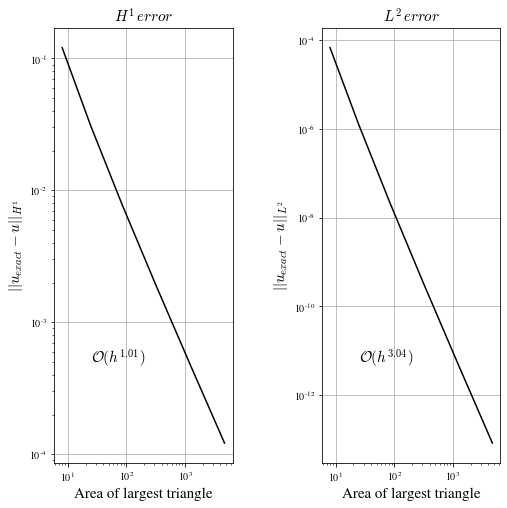

In [6]:
%matplotlib inline


# Define functions

def U_exact(x,y):

    return  np.sin(3*x)*np.cos(y) 


def F(x,y):
    return 10*np.sin(3*x)*np.cos(y)


def red_refinement(N,num):
    """
    N = starting number of nodes, i  = number of refinements
    returns an array of # of nodes along each axis at each stage
    """
    ref = [N]
    for n in range(num-1):
        ref.append(2*ref[n]-1)

    return ref

# Square Domain
H1_error = []
L2_error = []

Ns = red_refinement(4, 7)

for N in Ns[:-1]:
    E, Nodes, Mesh = Square_Triangulate(N)
    M = Stiffness(E, Nodes)
    [U, G_init] = Solve(Square_Triangulate, N, U_exact, F, on_boundary)
    U_refine, E_r, Nodes_r, Mesh_r = refine(Square_Triangulate, N, Nodes, U)
    e_h1 = H1_norm(E_r, Nodes_r, U_refine-U_exact(Mesh_r[0], Mesh_r[1]))
    e_l2 = H1_norm(E_r, Nodes_r, U_refine-U_exact(Mesh_r[0], Mesh_r[1]), which = "L2")
    H1_error.append(e_h1)
    L2_error.append(e_l2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8))
    
hs = np.array(Ns)*np.array(Ns)/2
m = np.log(H1_error[-2]/H1_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[0].loglog(hs[:-1], H1_error, c = "k")
ax[0].text(hs[1], H1_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()
plt.savefig("Plots_Assign3/Poisson_convergence.png")


hs = np.array(Ns)*np.array(Ns)/2
m = np.log(L2_error[-2]/L2_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[1].loglog(hs[:-1], L2_error, c = "k")
ax[1].text(hs[1], L2_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.subplots_adjust(wspace = 0.5)
plt.savefig("Plots_Assign3/Poisson_convergence_L2.png")


We note that the extra order of convergence in the $L^2$ norm could be due to our refinement procedure. Perhaps we would need to consider an extra layer of refinement and averaging to observe the correct order of convergence in the solution. (or perhaps a conceptual misunderstanding of course...). 

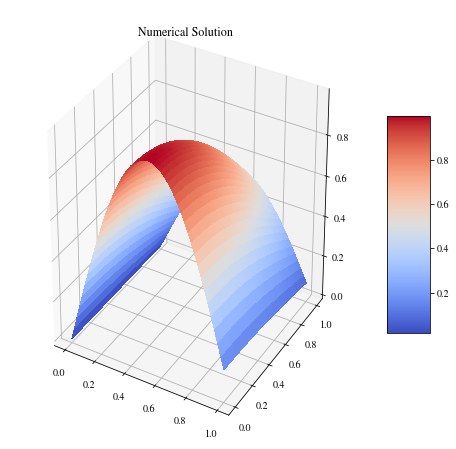

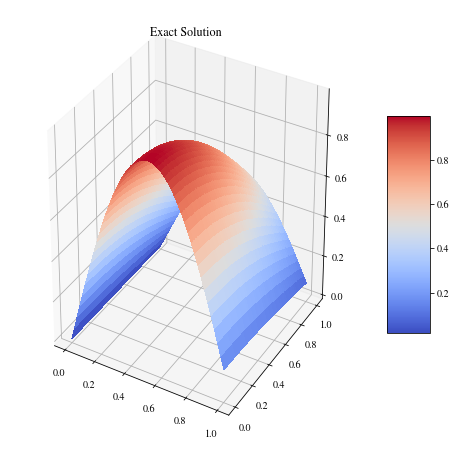

In [7]:
%matplotlib inline

fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Mesh[0], Mesh[1], G_init, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Numerical Solution")

fig = plt.figure(figsize = (8,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(Mesh[0], Mesh[1], G_init, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.title("Exact Solution")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig("Plots_Assign3/G.png")

---

## <center> Domain with reentrant corner </center>

We now consider the same numerical experiment, except now on a domain with a reentrant corner. The particular domain is depicted below.

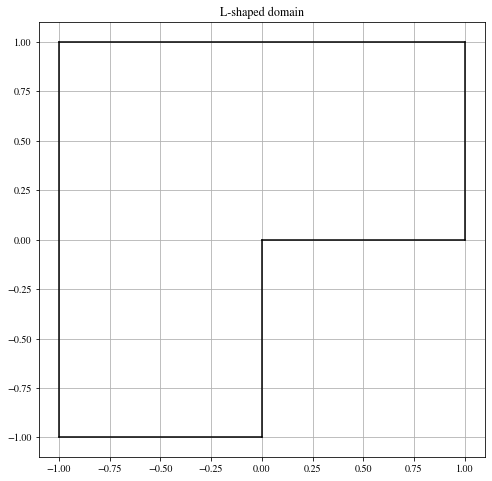

In [8]:
%matplotlib inline

fig = plt.figure(figsize = (8,8))
plt.plot([-1,0], [-1,-1], c = "k")
plt.plot([-1,-1], [-1,1], c = "k")
plt.plot([0,0], [-1,0], c = "k")
plt.plot([0,1], [0,0], c = "k")
plt.plot([1,1], [0,1], c = "k")
plt.plot([-1,1], [1,1], c = "k")
plt.grid()
plt.title("L-shaped domain")
plt.show()

Using the same function as before we again compute the $H^1$ and $L^2$ error. This time the refinement procedure is slightly changed since the geometry complicates things slightly. The value at each node is changed to an averaged value within an element that contains the node. 

Note: This is a bit of a hack and I hope it does not skew the results...

In [10]:
# %matplotlib inline
# # Triangulate domain with reentrant corner:

def L_Triangulate2(N):

    #stiching together two rectangular domains, with corner at origin
    # N has to be even
    x_lower = np.linspace(-1, 0, int(N/2), endpoint = True)
    x_upper = np.linspace((2/N), 1, int(N/2), endpoint = True)
    y_lower = np.linspace(-1,0, int(N/2), endpoint = True)
    y_upper = np.linspace(0, 1, int(N/2), endpoint = True)

    #lower left quadrant
    [X_ll,Y_ll] = np.meshgrid(x_lower, y_lower)
    
    #upper left
    [X_ul, Y_ul] = np.meshgrid(x_lower, y_upper)
    
    #upper right 
    [X_ur, Y_ur] = np.meshgrid(x_upper, y_upper)

#     #surmised to do this strange ordering
#     left_row = X_ul[0,:]
#     r_row = X_ur[0,:]
    
#     X_ul[1::2, :] = r_row
#     X_ur[1::2, :] = l_row
    
    
    #combine the two lists
    X = np.array(list(X_ll) + list(X_ul) + list(X_ur))
    Y = np.array(list(Y_ll) + list(Y_ul) + list(Y_ur))

    Nodes = np.zeros([int((3/4)*N**2), 3])
    Nodes[:,0], Nodes[:,1], Nodes[:,2] = np.arange(0,int((3/4)*N**2), dtype = int), \
    X.reshape([int((3/4)*N**2),]), Y.reshape([int((3/4)*N**2),])

    # Labelling will be from left to right, from bottom to top.

    # Need a way of identifying elements in order to define stiffness matrices

    # Create element (M X 4) data structure:
    # M is the number of elements

    # E = [lower left node | next nearest node | next nearest node]

    # Have to assemble elements per quadrant
    M = 3*N*(int(N/2)-1)  # total number of elements

    E = np.zeros([M-2, 4], dtype = int)  # -2 to account for indexing from 0
    E[:,0] = np.arange(0, M-2, dtype = int) # "--------=----------"

    #triangulation
    for i in range(0, (int(N/2)-1)*int(N/2) -1):
        #triangle below
        E[2*i,1] = int(i)
        E[2*i,2] = int(i + 1)
        E[2*i,3] = int(i + N + 1)

        #triangle above
        E[2*i+1,1] = int(i)
        E[2*i+1,2] = int(i + N)
        E[2*i+1,3] = int(i+ N + 1)
        
    for i in range((int(N/2)-1)*int(N/2) -1, (N-1)*int(N/2) -1):
        #triangle below
        E[2*i,1] = int(i)
        E[2*i,2] = int(i + 1)
        E[2*i,3] = int(i + N + 1)

        #triangle above
        E[2*i+1,1] = int(i)
        E[2*i+1,2] = int(i + N)
        E[2*i+1,3] = int(i+ N + 1)

    return E , Nodes, [X,Y]


def L_Triangulate(N):

    #stiching together two rectangular domains, with corner at origin
    x_lower = np.linspace(-1, 0, N, endpoint = True)
    y_lower = np.linspace(-1, 0, int(N/2), endpoint = False)

    x_upper = np.linspace(-1, 1, N, endpoint = True)
    y_upper = np.linspace(0, 1, int(N/2), endpoint = True)
    [X_u,Y_u] = np.meshgrid(x_upper, y_upper)
    [X_l,Y_l] = np.meshgrid(x_lower, y_lower)

    #combine the two lists
    X = np.array(list(X_l) + list(X_u))
    Y = np.array(list(Y_l) + list(Y_u))

    Nodes = np.zeros([N**2, 3])
    Nodes[:,0], Nodes[:,1], Nodes[:,2] = np.arange(0,int(N**2), dtype = int), X.reshape([N**2,]), Y.reshape([N**2,])

    # Labelling will be from left to right, from bottom to top.

    # Need a way of identifying elements in order to define stiffness matrices

    # Create element (M X 4) data structure:
    # M is the number of elements

    # E = [lower left node | next nearest node | next nearest node]
    M = 2*N*(N-1)
    E = np.zeros([M-2, 4], dtype = int)  # -2 to account for indexing from 0
    E[:,0] = np.arange(0, M-2, dtype = int) # "--------=----------"

    #triangulation
    for i in range(0, (N-1)*N -1):
        #triangle below
        E[2*i,1] = int(i)
        E[2*i,2] = int(i + 1)
        E[2*i,3] = int(i + N + 1)

        #triangle above
        E[2*i+1,1] = int(i)
        E[2*i+1,2] = int(i + N)
        E[2*i+1,3] = int(i+ N + 1)


    return E, Nodes, [X,Y]


## Refinement for L domain has to be slightly modified:

def refine_L(E, Nodes, U, N):
    
    # refine solution in order to avoid evaulating exactly at nodes:
    # Use even number N
    # Only going to consider middle point of element
    coords = np.zeros([len(E[:,0]), len(E[:,0])])
    U_ref = []
    u = U.reshape([N**2,]).copy()
    U_new = u.copy()
    i = 0
    for row in E:
        [X, Y] = [Nodes[row[1::], 1], Nodes[row[1::], 2]]
        x_c, y_c = np.sum(X)/3, np.sum(Y)/3
        u_c = np.sum(u[row[1::]])/3
        U_ref.append(u_c)
        coords[i,0], coords[i,1] = x_c, y_c
        U_new[row[1::]] = u_c
        i+=1
        
    
    return U_ref, U_new.reshape([N,N]), coords


-0.49184071465098894
0.9807926444803395


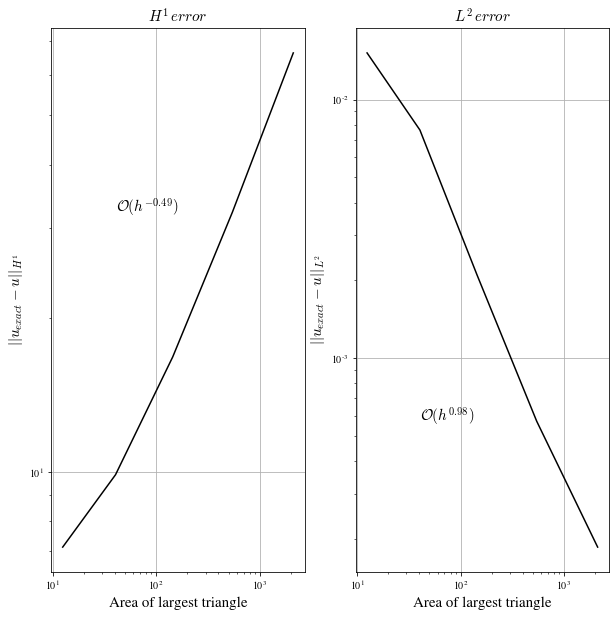

In [11]:
%matplotlib inline
# Define functions

def U_exact(x,y):

    return  np.sin(3*x)*np.cos(y) #np.exp(x)*np.sin(y)  # 1 + x**2 + 2*(y**2)

def F(x,y):
    return 10*np.sin(3*x)*np.cos(y)


def red_refinement(N,num):
    """
    N = starting number of nodes, i  = number of refinements
    returns an array of # of nodes along each axis at each stage
    """
    ref = [N]
    for n in range(num-1):
        ref.append(2*ref[n]-1)

    return ref

# Square Domain
H1_error = []
L2_error = []

Ns = red_refinement(5, 5)
for N in Ns:
    N = N +1
    E, Nodes, Mesh = L_Triangulate(N)
    M = Stiffness(E, Nodes)
    [U, G_init] = Solve(L_Triangulate, N, U_exact, F, on_boundary)
    U_refine, U_new, coords = refine_L(E, Nodes, U.reshape([N**2,]), N)
    e_h1 = H1_norm(E, Nodes, U_new - G_init)
    e_l2 = H1_norm(E, Nodes, U_new - G_init, which = "L2")
    H1_error.append(e_h1)
    L2_error.append(e_l2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
    
hs = np.array(Ns)*np.array(Ns)/2
m = np.log(H1_error[-2]/H1_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[0].loglog(hs, H1_error, c = "k")
ax[0].text(hs[1], H1_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()
plt.savefig("Plots_Assign3/L_domain_Poisson_convergenceH1.png")


hs = np.array(Ns)*np.array(Ns)/2
m = np.log(L2_error[-2]/L2_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[1].loglog(hs, L2_error, c = "k")
ax[1].text(hs[1], L2_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.savefig("Plots_Assign3/L_domain_Poisson_convergence_L2.png")



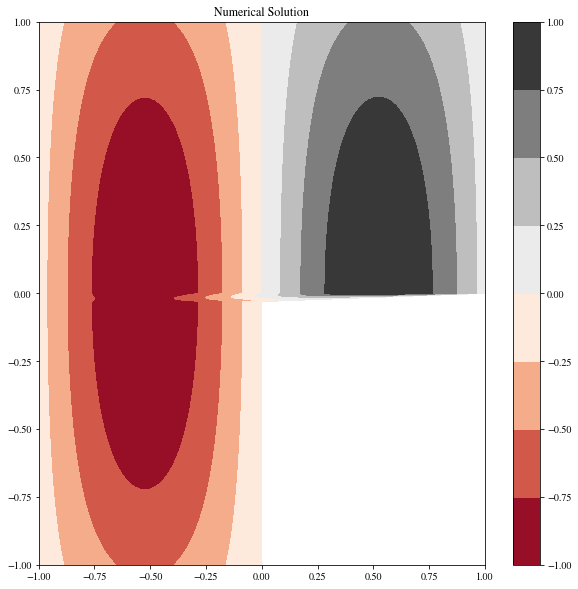

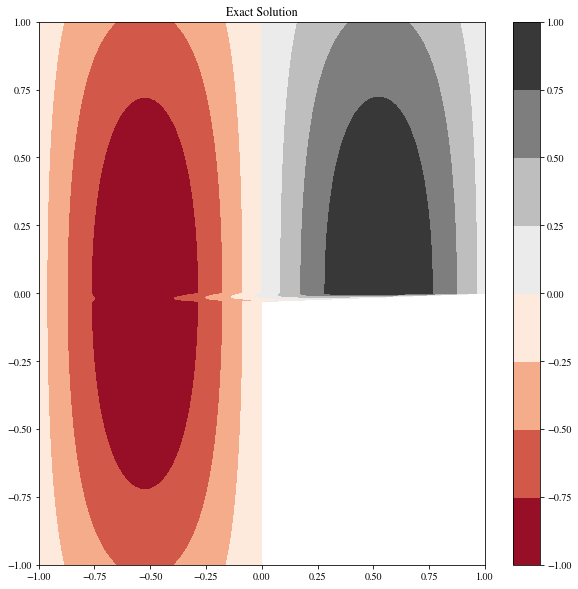

In [12]:
fig = plt.figure(figsize  = (10,10))
plt.contourf(Mesh[0], Mesh[1], U, cmap='RdGy')
plt.colorbar()

plt.title("Numerical Solution")
plt.savefig("Plots_Assign3/U_L.png")

fig = plt.figure(figsize= (10,10))
plt.contourf(Mesh[0], Mesh[1], G_init, cmap='RdGy')
plt.colorbar()
plt.title("Exact Solution")
plt.savefig("Plots_Assign3/G_L.png")

The convergence rates from our numerical experiment with the convex domain are no longer the same, this is due to the lack of convexity in this domain. The estimates were based on the averaged Taylor polynomial over a convex domain. For elements near the origin, this averaging procedure breaks down. 

Although, I suspect this is not the source of the error, and rather it has to do with the triangulation, as can be seen in the irregularity in the middle of the exact solution plotted above. This is since I was trying to preserve the number of nodes to be the same as in the square domain, I end up with an irregular grid spacing. Whereas for the function L_Triangulate2(), an even spacing is implemented.

This can be readily seen from the plots below:

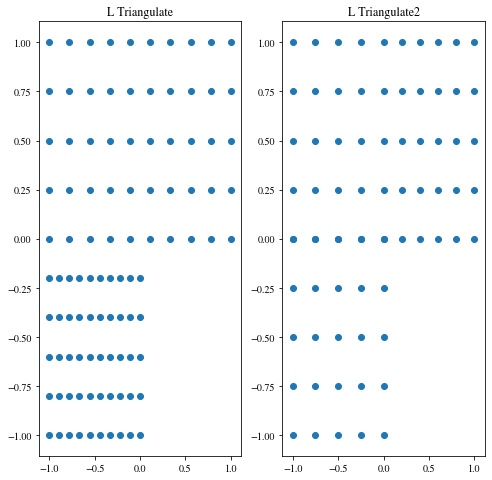

In [13]:
%matplotlib inline
E, Nodes, [X1,Y1] = L_Triangulate(10)
E, Nodes, [X2,Y2] = L_Triangulate2(10)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8))
ax[0].scatter(X1, Y1)
ax[0].set_title("L Triangulate")
ax[1].scatter(X2, Y2)
ax[1].set_title("L Triangulate2")
plt.show()




Moreover, we note that before the refinement the implementation yields convergent results in both norms, as depicted below:

2.0424735105307623
3.030913233192228


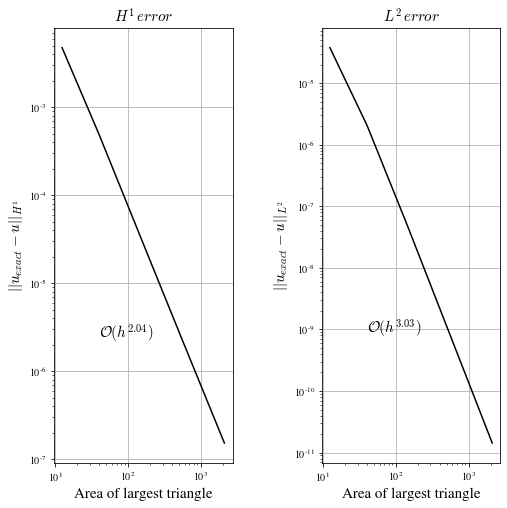

In [14]:
%matplotlib inline
# Square Domain
H1_error = []
L2_error = []

Ns = red_refinement(5, 5)
for N in Ns:
    N = N +1
    E, Nodes, Mesh = L_Triangulate(N)
    M = Stiffness(E, Nodes)
    [U, G_init] = Solve(L_Triangulate, N, U_exact, F, on_boundary)
    e_h1 = H1_norm(E, Nodes, U - G_init)
    e_l2 = H1_norm(E, Nodes, U - G_init, which = "L2")
    H1_error.append(e_h1)
    L2_error.append(e_l2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8))
    
hs = np.array(Ns)*np.array(Ns)/2
m = np.log(H1_error[-2]/H1_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[0].loglog(hs, H1_error, c = "k")
ax[0].text(hs[1], H1_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()

hs = np.array(Ns)*np.array(Ns)/2
m = np.log(L2_error[-2]/L2_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[1].loglog(hs, L2_error, c = "k")
ax[1].text(hs[1], L2_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.subplots_adjust(wspace = 0.5)
plt.show()

This is merely a reflection that the solver has been made sufficiently general to handle arbitrary domains but my refinement procedures and data structures for the L-shaped domain were not sufficiently general. I have included these remarks because I'd like to be transparent and aware of the origin of the error in my solution, rather than negligent. 

---



We now consider a function of the form:

\begin{equation*}
u(r,\theta) = r^{2/3} \sin\left(\frac{2}{3} \theta\right)
\end{equation*}



-0.005959816753769444
0.9795098738695163


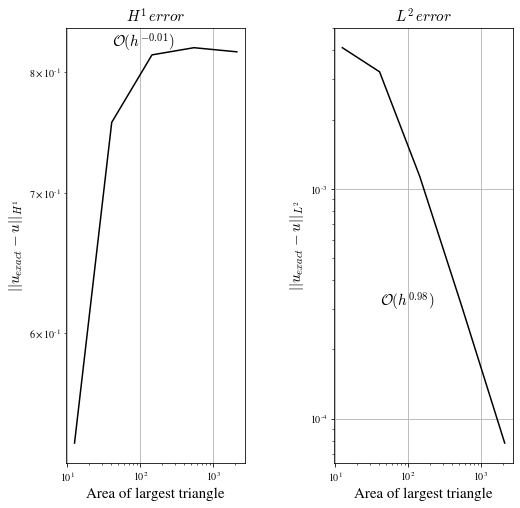

In [15]:
#L-shaped domain

def u_r_exact(x,y):
    ((x**2 + y**2)**(1/3))*np.sin(np.arctan(y/x))

def F(x,y):
    return 0*x

# Square Domain
H1_error = []
L2_error = []

Ns = red_refinement(5, 5)
for N in Ns:
    N = N +1
    E, Nodes, Mesh = L_Triangulate(N)
    M = Stiffness(E, Nodes)
    [U, G_init] = Solve(L_Triangulate, N, U_exact, F, on_boundary)
    U_refine, U_new, coords = refine_L(E, Nodes, U.reshape([N**2,]), N)
    e_h1 = H1_norm(E, Nodes, U - G_init)
    e_l2 = H1_norm(E, Nodes, U - G_init, which = "L2")
    H1_error.append(e_h1)
    L2_error.append(e_l2)


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8))
    
hs = np.array(Ns)*np.array(Ns)/2
m = np.log(H1_error[-2]/H1_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[0].loglog(hs, H1_error, c = "k")
ax[0].text(hs[1], H1_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[0].set_xlabel("Area of largest triangle", fontsize = 15)
ax[0].set_ylabel(r"$||u_{exact} - u||_{H^1}$", fontsize = 15)
ax[0].set_title(r"$H^1 \, error$", fontsize = 15)
ax[0].grid()
plt.savefig("Plots_Assign3/radial_Poisson_convergenceH1.png")


hs = np.array(Ns)*np.array(Ns)/2
m = np.log(L2_error[-2]/L2_error[-3])/np.log((hs[-2]/hs[-3]))
print(-m)
ax[1].loglog(hs, L2_error, c = "k")
ax[1].text(hs[1], L2_error[-2],r"$\mathcal{O}(h^{%1.2f})$" %(-m), fontsize = 15)
ax[1].set_xlabel("Area of largest triangle", fontsize = 15)
ax[1].set_ylabel(r"$||u_{exact} - u||_{L^2}$", fontsize = 15)
ax[1].set_title(r"$L^2 \, error$", fontsize = 15)
ax[1].grid()
plt.subplots_adjust(wspace = 0.5)
plt.savefig("Plots_Assign3/radial_Poisson_convergence_L2.png")



These convergence rates are due to the regularity of the solution. As seen in question 5 of assignment 1, the function is $L^p$ integrable for p > -2/a $\Rightarrow$ since 2 > -3, convergence in the $L^2$ norm is expected. For the radial derivatives of this function, the condition for integrability was given by $p > -2/(a-1)$, i.e. $p>6$. Since we measure the error in the derivatives in the $L^2$ norm, the divergence is expected. If I were more certain about my implementation, then some remarks could be made about the rates of convergence but the rates are not an accurate reflection of the theory behind them in this case. 